In [1]:
import os
import numpy as np
import pandas as pd

os.chdir('../core')

In [2]:
DATA_DIR = "../data"
FILE_NAME = "train.csv"

df = pd.read_csv(os.path.join(DATA_DIR, FILE_NAME))
df = df.drop(columns=["Employee ID"])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df["Attrition"] = df["Attrition"].map({"Stayed": 1, "Left": 0})
print(df.shape)

df.head(5)

(59598, 23)


,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,29,Female,10,Education,4262,Fair,Medium,High,0,Yes,...,0,Senior,Small,52,No,No,No,Poor,High,1
1,18,Male,3,Finance,9032,Good,Very High,High,3,Yes,...,3,Entry,Medium,50,No,No,No,Good,Medium,0
2,30,Female,9,Healthcare,8610,Poor,Medium,Average,2,No,...,4,Entry,Large,62,No,No,No,Fair,Low,0
3,46,Male,2,Education,5071,Fair,High,Average,1,Yes,...,0,Entry,Small,39,No,No,No,Good,High,0
4,37,Male,17,Technology,10037,Fair,High,Average,0,No,...,1,Mid,Medium,42,No,No,No,Good,Low,0


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from processor import LabelEncoderTransformer


target_column = "Attrition"

# Choose numeric columns except the target column
numeric_columns = df.drop(columns=[target_column]).select_dtypes(include=['int64', 'float64']).columns.tolist()
category_columns = df.select_dtypes(include=['object']).columns.tolist()

processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', LabelEncoderTransformer(), category_columns)
    ]
)

X = processor.fit_transform(df.drop(columns=[target_column]), df[target_column])
y = df[target_column].values.reshape(-1, 1)

X

array([[-0.79190512, -0.51164494, -1.4131925 , ...,  0.        ,
         3.        ,  0.        ],
       [-1.70253344, -1.13409473,  0.80392784, ...,  0.        ,
         2.        ,  2.        ],
       [-0.70912073, -0.60056634,  0.60778009, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.0359388 , -1.22301613, -1.15662008, ...,  0.        ,
         2.        ,  1.        ],
       [-0.87468951,  0.02188346,  1.39515994, ...,  0.        ,
         2.        ,  2.        ],
       [-0.21241438,  0.64433325, -1.38019134, ...,  0.        ,
         2.        ,  2.        ]])

In [22]:
from base import (
    LogisticRegressionGD,
    LogisticRegressionBatchGD,
    LogisticRegressionPA,
    LogisticRegressionNewton,
    LogisticRegressionBFGS,
    LogisticRegressionAdam
)

num_interations = 200
regularization = "l1"
lambda_ = 0.01

base_gd = LogisticRegressionGD(
    learning_rate=0.1,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

sgd = LogisticRegressionBatchGD(
    learning_rate=0.1,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
    batch_size=1,
)

minibatch_gd = LogisticRegressionBatchGD(
    learning_rate=0.1,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
    batch_size=32,
)

pa = LogisticRegressionPA(
    learning_rate=0.1,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

newton = LogisticRegressionNewton(
    learning_rate=0.5,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

bfgs = LogisticRegressionBFGS(
    learning_rate=0.1,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

adam = LogisticRegressionAdam(
    learning_rate=0.1,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

models = [
    base_gd, 
    # sgd, 
    minibatch_gd, 
    pa, 
    newton, 
    bfgs, 
    adam
]

names = [
    "GD", 
    # "SGD", 
    "Mini-batch GD (32)", 
    "Accelerated GD", 
    "Newton", 
    "BFGS", 
    "Adam"
]

loggers = []
for model, name in zip(models, names):
    logger = {}
    model.fit(X, y)

    logger["name"] = name
    logger["loss"] = model.history
    logger["time"] = model.times
    
    loggers.append(logger)

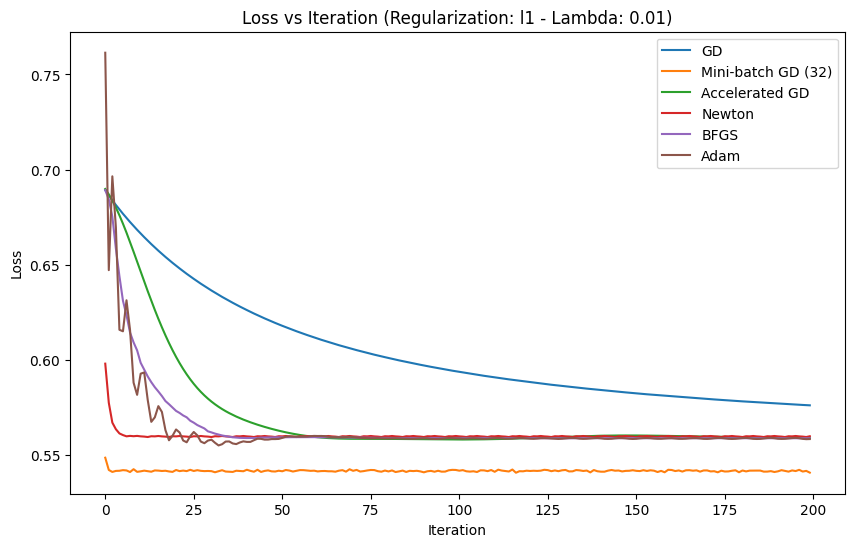

In [23]:
# Plot loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for logger in loggers:
    plt.plot(logger["loss"], label=logger["name"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
if regularization == "None":
    plt.title(f"Loss vs Iteration (No Regularization)")
else:
    plt.title(f"Loss vs Iteration (Regularization: {regularization} - Lambda: {lambda_})")

plt.show()

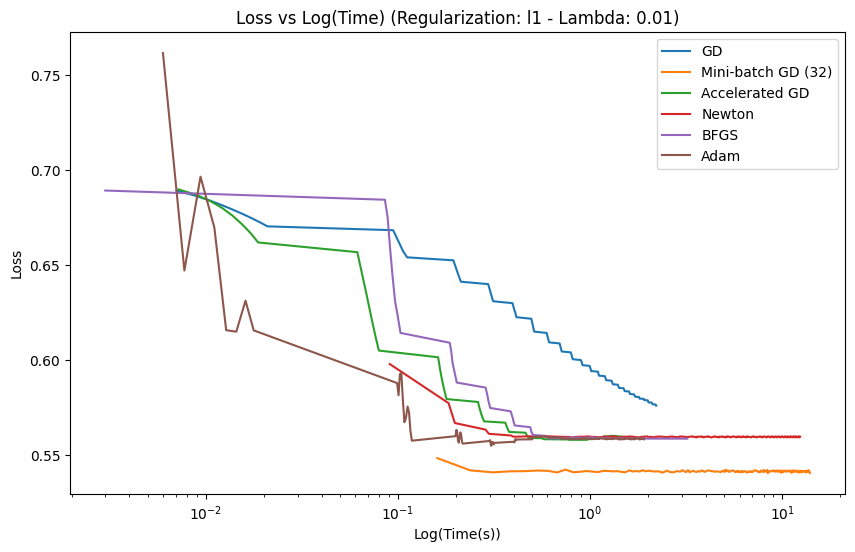

In [24]:
plt.figure(figsize=(10, 6))
for logger in loggers:
    plt.plot(logger["time"], logger["loss"], label=logger["name"])
plt.xlabel("Log(Time(s))")
plt.ylabel("Loss")
plt.legend()
if regularization == "None":
    plt.title("Loss vs Log(Time) - No Regularization")
else:
    plt.title(f"Loss vs Log(Time) (Regularization: {regularization} - Lambda: {lambda_})")

plt.xscale("log")
plt.show()

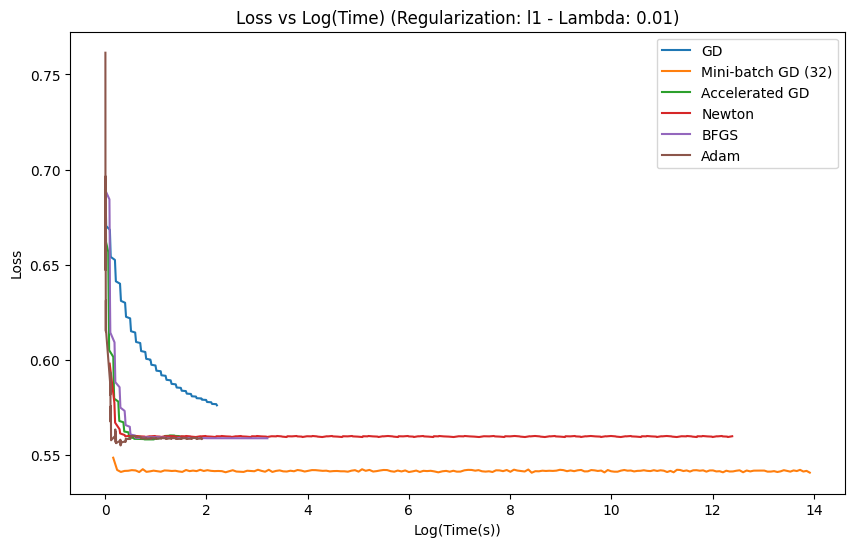

In [25]:
plt.figure(figsize=(10, 6))
for logger in loggers:
    plt.plot(logger["time"], logger["loss"], label=logger["name"])
plt.xlabel("Log(Time(s))")
plt.ylabel("Loss")
plt.legend()
if regularization == "None":
    plt.title("Loss vs Log(Time) - No Regularization")
else:
    plt.title(f"Loss vs Log(Time) (Regularization: {regularization} - Lambda: {lambda_})")

# plt.xscale("log")
plt.show()

In [6]:
from sklearn.linear_model import LogisticRegression
from time import time
from base import (
    LogisticRegressionGD,
    LogisticRegressionBFGS,
)

# Params
num_iterations = 200
lambda_ = 1.0

sklearn_model = LogisticRegression(penalty=None)

base_gd = LogisticRegressionGD(
    learning_rate=0.1,
    num_iterations=num_iterations,
    regularization="None",
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

bfgs = LogisticRegressionBFGS(
    learning_rate=0.1,
    num_iterations=num_iterations,
    regularization="None",
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

models = [sklearn_model, base_gd, bfgs]
names = [
    "Sklearn Logistic Regression", 
    "Gradient Descent (Ours)", 
    "BFGS (Ours)"
]


def loss_fn(y, h):
    return -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

loggers = []
history = []
times = []
for i in range(1, num_iterations):
    model = LogisticRegression(penalty=None, max_iter=i)
    start = time()
    model.fit(X, y.ravel())
    end = time()

    # Get weights and bias
    weights = model.coef_
    bias = model.intercept_
    theta = np.concatenate((bias, weights[0])).reshape(-1, 1)

    # Calculate loss
    X_ = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    h = sigmoid(np.dot(X_, theta))
    loss = loss_fn(y, h)

    history.append(loss)
    times.append(end - start)

loggers.append({
    "name": "Sklearn Logistic Regression",
    "loss": history,
    "time": times
})

for model, name in zip(models[1:], names[1:]):
    logger = {}
    model.fit(X, y)

    logger["name"] = name
    logger["loss"] = model.history
    logger["time"] = model.times
    
    loggers.append(logger)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

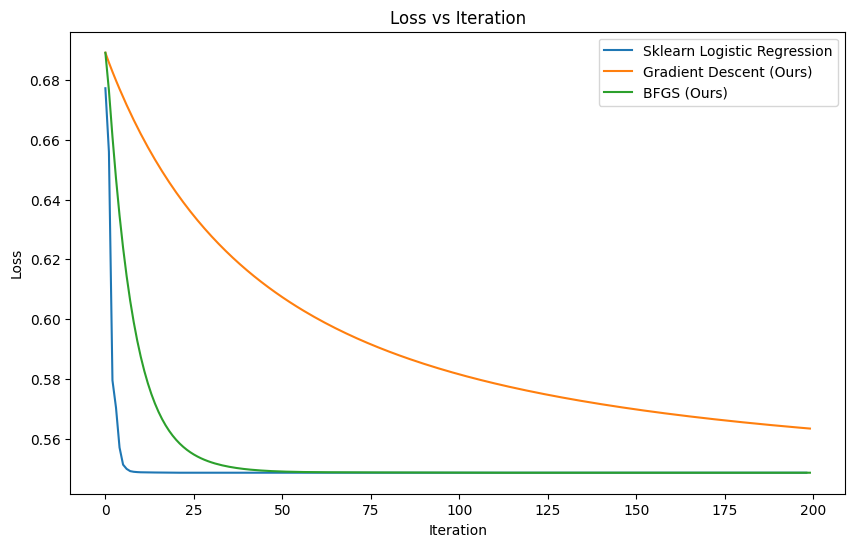

In [7]:
# Plot loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for logger in loggers:
    plt.plot(logger["loss"], label=logger["name"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Iteration")
plt.show()

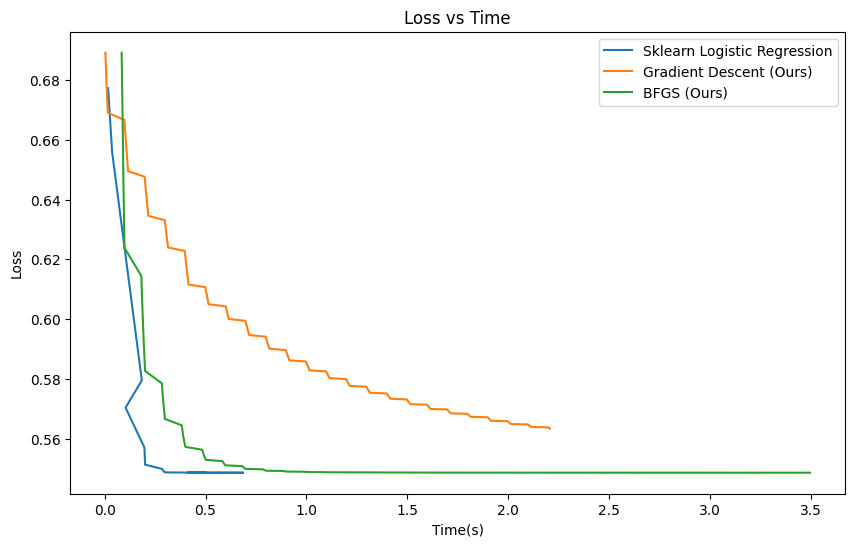

In [8]:
plt.figure(figsize=(10, 6))
for logger in loggers:
    plt.plot(logger["time"], logger["loss"], label=logger["name"])
plt.xlabel("Time(s)")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Time")
plt.show()